# Test

In [ ]:
from ultralytics import YOLO
from autoencoder import DNIAnomalyDetector
import torch
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import transforms
import numpy as np
from tqdm import tqdm
import os

def crop_image(image, bbox):
    """Crop image using bounding box coordinates."""
    x1, y1, x2, y2 = [int(coord) for coord in bbox]
    return image.crop((x1, y1, x2, y2))

def process_image(image_path, yolo_model, detector, loss_weights):
    """
    Process a single image: YOLO for cropping, then Autoencoder for validation.
    """
    # Usar YOLO solo para detectar y recortar
    results = yolo_model(image_path)[0]

    # Si no hay detecciones, usar la imagen original
    if len(results.boxes) == 0:
        return detector.predict(image_path, loss_weights=loss_weights)

    # Obtener la detección con mayor confianza para el recorte
    confidences = results.boxes.conf.cpu().numpy()
    best_idx = confidences.argmax()
    box = results.boxes[best_idx]

    # Recortar imagen usando el bbox
    original_image = Image.open(image_path)
    bbox = box.xyxy[0].cpu().numpy()
    cropped_image = crop_image(original_image, bbox)

    # Guardar temporalmente la imagen recortada
    temp_crop_path = f"temp_crop_{os.path.basename(image_path)}"
    try:
        cropped_image.save(temp_crop_path)
        # Validar con Autoencoder
        return detector.predict(temp_crop_path, loss_weights=loss_weights)
    finally:
        if os.path.exists(temp_crop_path):
            os.remove(temp_crop_path)

def test_detector(model_path, yolo_path, test_dir, anomaly_threshold=0.5, loss_weights={'mse': 1.0, 'ssim': 0.0}):
    """
    Test the DNI Anomaly Detector with YOLO preprocessing for cropping.
    """
    # Initialize models
    yolo_model = YOLO(yolo_path)
    detector = DNIAnomalyDetector()
    detector.load_model(model_path)
    
    # Print configuration
    print("\nModel Configuration:")
    print(f"Autoencoder Threshold: {detector.threshold:.6f}")
    print(f"Loss Weights: MSE={loss_weights['mse']}, SSIM={loss_weights['ssim']}")
    print(f"Anomaly Classification Threshold: {anomaly_threshold}")
    
    # Process test images
    test_path = Path(test_dir)
    test_images = list(test_path.glob('*.jpg'))
    
    results = []
    confidences = []
    
    print("\nTesting images...")
    with torch.no_grad():
        for img_path in tqdm(test_images, desc="Processing images"):
            try:
                confidence = process_image(str(img_path), yolo_model, detector, loss_weights)
                confidences.append(confidence)
                
                results.append({
                    'image': str(img_path),
                    'confidence': confidence,
                    'is_anomaly': confidence < anomaly_threshold
                })
                
                print(f"\nImage: {img_path.name}")
                print(f"Confidence: {confidence:.4f}")
                print(f"Is anomaly: {confidence < anomaly_threshold}")
                
            except Exception as e:
                print(f"\nError processing {img_path.name}: {str(e)}")
                continue
    
    if not confidences:
        print("\nNo images were processed!")
        return results
    
    # Calculate statistics
    confidences = np.array(confidences)
    
    print("\nConfidence Score Statistics:")
    print(f"Min confidence: {confidences.min():.4f}")
    print(f"Max confidence: {confidences.max():.4f}")
    print(f"Mean confidence: {confidences.mean():.4f}")
    print(f"Median confidence: {np.median(confidences):.4f}")
    print(f"Std confidence: {confidences.std():.4f}")
    
    # Print detailed results
    print("\nDetailed Results:")
    confidence_ranges = {
        'Very Low (0.0-0.2)': 0,
        'Low (0.2-0.4)': 0,
        'Medium (0.4-0.6)': 0,
        'High (0.6-0.8)': 0,
        'Very High (0.8-1.0)': 0
    }
    
    for result in results:
        conf = result['confidence']
        if conf < 0.2:
            confidence_ranges['Very Low (0.0-0.2)'] += 1
        elif conf < 0.4:
            confidence_ranges['Low (0.2-0.4)'] += 1
        elif conf < 0.6:
            confidence_ranges['Medium (0.4-0.6)'] += 1
        elif conf < 0.8:
            confidence_ranges['High (0.6-0.8)'] += 1
        else:
            confidence_ranges['Very High (0.8-1.0)'] += 1
    
    for range_name, count in confidence_ranges.items():
        print(f"{range_name}: {count} images ({(count/len(results))*100:.1f}%)")
    
    # Print classification summary
    anomalies = sum(1 for r in results if r['is_anomaly'])
    print(f"\nClassification Summary:")
    print(f"Total images tested: {len(results)}")
    print(f"Anomalies detected: {anomalies} ({(anomalies/len(results))*100:.1f}%)")
    print(f"Normal images: {len(results) - anomalies} ({((len(results)-anomalies)/len(results))*100:.1f}%)")
    
    # Plot histogram
    plt.figure(figsize=(10, 6))
    plt.hist(confidences, bins=50, edgecolor='black')
    plt.title('Distribution of Confidence Scores')
    plt.xlabel('Confidence Score')
    plt.ylabel('Number of Images')
    plt.axvline(x=anomaly_threshold, color='r', linestyle='--', label=f'Anomaly Threshold ({anomaly_threshold})')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.savefig('confidence_distribution.png')
    plt.close()
    
    return results

# Example usage
if __name__ == "__main__":
    model_path = "api/dni_anomaly_detector.pt"
    yolo_path = "YOLODataset_seg/runs/segment/train2/weights/best.pt"
    test_dir = "test/valid"
    
    results = test_detector(
        model_path=model_path,
        yolo_path=yolo_path,
        test_dir=test_dir,
        anomaly_threshold=0.85,
        loss_weights={'mse': 1.0, 'ssim': 0.0}
    )

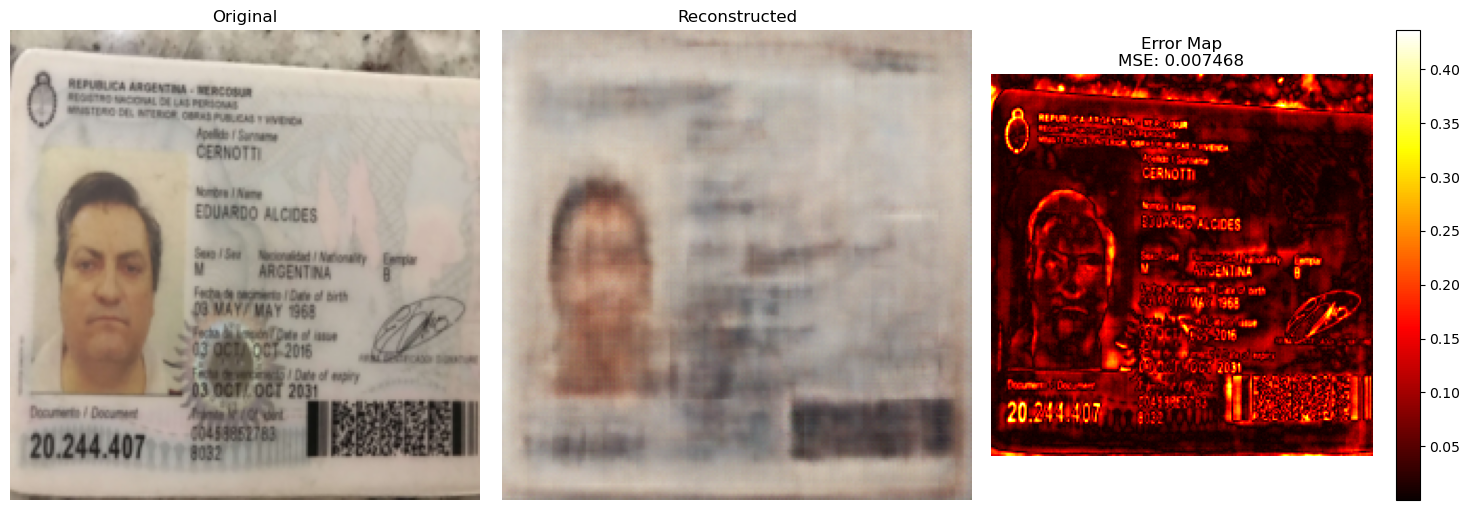

0.007468441501259804

In [6]:
import torch
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from torchvision import transforms

def test_autoencoder(model, image_path, save_path=None):
    """
    Test the autoencoder by reconstructing an image and visualizing the results.
    
    Args:
        model: DNIAnomalyDetector instance
        image_path: Path to the test image
        save_path: Optional path to save the visualization
    """
    # Prepare image
    image = Image.open(image_path).convert('RGB')
    image_tensor = model.transform(image).unsqueeze(0).to(model.device)
    
    # Get reconstruction
    model.encoder.eval()
    model.decoder.eval()
    with torch.no_grad():
        latent = model.encoder(image_tensor)
        reconstructed = model.decoder(latent)
    
    # Calculate reconstruction error
    mse_loss = torch.nn.functional.mse_loss(reconstructed, image_tensor).item()
    
    # Convert tensors to images for plotting
    original_img = image_tensor.squeeze(0).cpu().numpy().transpose(1, 2, 0)
    reconstructed_img = reconstructed.squeeze(0).cpu().numpy().transpose(1, 2, 0)
    
    # Create figure
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # Plot original
    axes[0].imshow(original_img)
    axes[0].set_title('Original')
    axes[0].axis('off')
    
    # Plot reconstruction
    axes[1].imshow(reconstructed_img)
    axes[1].set_title('Reconstructed')
    axes[1].axis('off')
    
    # Plot error map
    error_map = np.abs(original_img - reconstructed_img).mean(axis=2)
    im = axes[2].imshow(error_map, cmap='hot')
    axes[2].set_title(f'Error Map\nMSE: {mse_loss:.6f}')
    axes[2].axis('off')
    plt.colorbar(im, ax=axes[2])
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path)
    plt.show()
    
    return mse_loss

def batch_test(model, test_dir, n_samples=5):
    """
    Test multiple images and show their reconstructions
    
    Args:
        model: DNIAnomalyDetector instance
        test_dir: Directory containing test images
        n_samples: Number of random samples to test
    """
    from pathlib import Path
    import random
    
    # Get list of images
    image_paths = list(Path(test_dir).glob('*.jpg'))
    
    # Select random samples
    if n_samples > len(image_paths):
        n_samples = len(image_paths)
    
    test_images = random.sample(image_paths, n_samples)
    
    # Test each image
    results = []
    for img_path in test_images:
        print(f"\nTesting {img_path.name}")
        mse = test_autoencoder(model, img_path)
        confidence = model.predict(img_path)
        results.append({
            'image': img_path.name,
            'mse': mse,
            'confidence': confidence
        })
        print(f"MSE: {mse:.6f}")
        print(f"Confidence Score: {confidence:.6f}")
    
    return results

# Cargar el modelo entrenado
detector = DNIAnomalyDetector(device='cuda' if torch.cuda.is_available() else 'cpu')
detector.load_model('api/dni_anomaly_detector.pt')

# Test de una sola imagen
test_autoencoder(detector, 'test/valid/0a1e89f6-0ae2-4cab-854e-61c897cbbe13.jpg', save_path='resultado.png')

# # Test de múltiples imágenes
# results = batch_test(detector, 'carpeta/con/imagenes', n_samples=5)